
## 비정제데이터 체험하기_ds2
# 4. Data transformation - 영국시장의 중고 자동차 가격 데이터 다루기 [프로젝트]
<br/>
<br/>

* 목표
    * 중고차 가격 예측

<br/>

* 할 일
  1. cars.csv와 brand.csv의 데이터 합치기
      * [힌트] cars.csv의 title 변수로부터 브랜드 데이터를 추출할 수 있습니다.
  2. 카테고리형 변수를 숫자 형태로 변환하기
      * [힌트] Engine, Emission Class 변수에 주목하세요!
  3. 결측치 처리하기
      * [힌트] Service history 변수의 결측치는 'Unknown'으로 채우고, 결측치 변수가 일정 개수 이상 포함된 데이터는 제거합니다.
  4. Scaler 활용해보기
  5. 기존 데이터의 정보 70% 이상을 가지는 수준에서 최소한의 주성분 추출 (PCA)
  6. 국가별 총 브랜드 개수
  7. 상관관계가 높은 변수들이 있는지 확인

<br/>

In [976]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [977]:
car_df = pd.read_csv('data_day4_dt/cars.csv')

In [978]:
brand_df = pd.read_csv('data_day4_dt/brand.csv')

<br/><br/>
# 데이터 둘러보기

1. title: 브랜드명 + 이름 조합

2. Price: 중고차 가격

3. Mileage(miles): 주행 거리

4. Registration_Year: 연식

5. Previous Owners: 이전 소유주 명 수

6. Fuel type: 연료 종류

7. Body type: 자동차 모양

8. Engine: 엔진

9. Gearbox: 기어 박스 종류

10. Doors: 문 개수

11. Seats: 좌석 개수

12. Emission Class: 배출가스 등급

13. Service history: 수리 내역
<br/><br/>

In [979]:
car_df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [980]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 374.6+ KB


In [981]:
brand_df.head()

,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


In [982]:
# 컬럼명 정리

car_df.rename(columns = {'title': 'Model', 'Mileage(miles)': 'Mileage',
                         'Registration_Year': 'Registration Year', 'Fuel type': 'Fuel Type',
                         'Body type': 'Body Type', 'Service history': 'Service History'}, inplace = True)
brand_df.rename(columns = {'title': 'Make', 'country': 'Country'}, inplace = True)

<br/><br/>
# cars 데이터와 brand 데이터 합치기
<br/><br/>

In [983]:
# brand.csv 데이터와 합치기 위해 'title' 컬럼을 'Brand(자동차 브랜드)'와 'Title(이름)'로 컬럼 분리

car_df[['Make', 'Model']] = car_df['Model'].str.split(' ', n = 1, expand = True)

In [984]:
# car_df 확인

car_df.head()

,Model,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make
0,FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA
1,CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL
2,I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI
3,HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI
4,CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL


In [985]:
# brand 데이터를 합치기 위한 준비. Make 컬럼 값 대문자로 변경

brand_df['Make'] = brand_df['Make'].str.upper()

In [986]:
# brand_df 확인

brand_df.head()

,Make,Country
0,SKODA,Czech Republic
1,VAUXHALL,United Kingdom
2,HYUNDAI,South Korea
3,MINI,United Kingdom
4,FORD,United States


In [987]:
car_df = car_df.merge(brand_df, on = 'Make', how = 'left')

<br/><br/>
# 고유값 확인 및 불필요한 컬럼 삭제

* 모델명(Model) 컬럼의 고유값이 많고, 온전하지 않은 데이터들이 보여서 디테일하게 살피며 정리가 필요한 상황
* 모델명(Model) 또한 가격 예측에 도움 되는 정보겠지만, 종류가 너무 많아서 현재로서는 오히려 예측에 방해될 것 같아서 삭제함
* 다른 'Fuel Type','Body Type','Gearbox', 'Service History', 'Make' 컬럼들은 고유값 개수가 적당함
<br/><br/>

In [988]:
# 컬럼 정보 확인

car_df.head()

,Model,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make,Country
0,FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA,Czech Republic
1,CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,United Kingdom
2,I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI,South Korea
3,HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,United Kingdom
4,CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL,United Kingdom


In [989]:
# 고유값 개수 확인
# 모델명(Model) 컬럼의 고유값이 많음 

car_df[['Model','Fuel Type','Body Type','Gearbox', 'Service History']].nunique()

Model              453
Fuel Type            6
Body Type           10
Gearbox              2
Service History      1
dtype: int64

In [990]:
# 모델명(Model)이 온전하지 않은 데이터들이 보여서 디테일하게 살피며 정리가 필요해보임

car_df['Model'].value_counts().tail(30)

GTO                                       1
MIDGET                                    1
CL                                        1
OUTBACK                                   1
FOCUS CC                                  1
GS 300                                    1
M                                         1
SPLASH                                    1
FORTWO                                    1
SHOGUN                                    1
A180                                      1
COUNTRYMAN                                1
B-CLASS                                   1
SORENTO                                   1
CX-3                                      1
CLUBMAN                                   1
GRAND CHEROKEE                            1
MX-30                                     1
ALMERA TINO                               1
LANCER                                    1
ZT                                        1
X6                                        1
PROTON                          

In [991]:
# 모델명(Model) 또한 가격 예측에 도움 되는 정보겠지만, 종류가 너무 많아서 현재로서는 오히려 예측에 방해될 것 같아서 삭제

car_df = car_df.drop(['Model'], axis = 1)

In [992]:
# 모델명(Model) 컬럼이 잘 삭제되었는지 확인

car_df.head()

,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make,Country
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA,Czech Republic
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,United Kingdom
2,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI,South Korea
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,United Kingdom
4,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL,United Kingdom


<br/><br/>
# 결측치 처리

1. Previous Owners 결측치 삭제

2. Engine, Doors, Seats, Emission Class 컬럼의 결측치 삭제

3. Service history 변수의 결측치 'Unknown'으로 변경
<br/><br/>

In [993]:
# 결측치 확인
# Previous Owners, Engine, Doors, Seats, Emission Class, Service history 컬럼에 결측치가 존재함

car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3687 entries, 0 to 3686
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              3687 non-null   int64  
 1   Mileage            3687 non-null   int64  
 2   Registration Year  3687 non-null   int64  
 3   Previous Owners    2276 non-null   float64
 4   Fuel Type          3687 non-null   object 
 5   Body Type          3687 non-null   object 
 6   Engine             3642 non-null   object 
 7   Gearbox            3687 non-null   object 
 8   Doors              3662 non-null   float64
 9   Seats              3652 non-null   float64
 10  Emission Class     3600 non-null   object 
 11  Service History    540 non-null    object 
 12  Make               3687 non-null   object 
 13  Country            3687 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 432.1+ KB


In [994]:
# 결측치 개수 확인

car_df.isna().sum()

Price                   0
Mileage                 0
Registration Year       0
Previous Owners      1411
Fuel Type               0
Body Type               0
Engine                 45
Gearbox                 0
Doors                  25
Seats                  35
Emission Class         87
Service History      3147
Make                    0
Country                 0
dtype: int64

In [995]:
# 결측치 비율 확인

car_df.isna().mean()

Price                0.000000
Mileage              0.000000
Registration Year    0.000000
Previous Owners      0.382696
Fuel Type            0.000000
Body Type            0.000000
Engine               0.012205
Gearbox              0.000000
Doors                0.006781
Seats                0.009493
Emission Class       0.023596
Service History      0.853539
Make                 0.000000
Country              0.000000
dtype: float64

In [996]:
# Previous Owners 결측치 처리
# 결측치 비율이 1,411개(38%)로 꽤 높지만, 다른 값으로 채웠다가 성능에 영향이 있을까 하여 삭제하기로 결정하였다.

car_df['Previous Owners'].describe()

count    2276.000000
mean        2.807557
std         1.546028
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: Previous Owners, dtype: float64

In [997]:
# Previous Owners 결측치 삭제

car_df = car_df.dropna(subset = ['Previous Owners'])

In [998]:
# Engine, Doors, Seats, Emission Class 결측치 삭제
# Engine, Doors, Seats, Emission Class는 결측치가 적은 편이어서 삭제하기로 결정하였다.

car_df = car_df.dropna(subset = ['Engine', 'Doors', 'Seats', 'Emission Class'])

In [999]:
# Service history 결측치 처리
# 결측치가 많아서 제거하면 데이터 손실이 큼
# 결측치를 'Unknown'으로 채워줌

car_df['Service History'] = car_df['Service History'].fillna('Unknown')

In [1000]:
# 결측치가 모두 처리되었는지 확인

car_df.isna().sum()

Price                0
Mileage              0
Registration Year    0
Previous Owners      0
Fuel Type            0
Body Type            0
Engine               0
Gearbox              0
Doors                0
Seats                0
Emission Class       0
Service History      0
Make                 0
Country              0
dtype: int64

<br/><br/>
# 이상치 처리

* 이상치로 추측되는 값이 없어, 특별히 처리할 값이 없음
<br/><br/>

In [1001]:
# 통계 요약값으로 이상치 확인

car_df.describe()

,Price,Mileage,Registration Year,Previous Owners,Doors,Seats
count,2239.000000,2.239000e+03,2239.000000,2239.000000,2239.000000,2239.000000
mean,5984.423403,8.293097e+04,2012.308620,2.805270,4.410004,4.930773
std,4761.228187,4.240144e+04,4.710367,1.540791,0.937172,0.591974
min,400.000000,6.000000e+00,1993.000000,1.000000,2.000000,2.000000
25%,2450.000000,5.839800e+04,2009.000000,2.000000,4.000000,5.000000
50%,4250.000000,8.000000e+04,2012.000000,3.000000,5.000000,5.000000
75%,8492.000000,1.050000e+05,2016.000000,4.000000,5.000000,5.000000
max,33900.000000,1.110100e+06,2023.000000,9.000000,5.000000,7.000000


In [1002]:
# Price 최솟값 400이 이상치는 아닌지 확인
# 가능한 가격인 것 같음

car_df.sort_values('Price').head(10)

,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make,Country
3245,400,120842,2010,4.0,Diesel,Hatchback,1.2L,Manual,3.0,5.0,Euro 5,Unknown,SEAT,Spain
1238,495,97000,2011,7.0,Diesel,Hatchback,1.7L,Manual,5.0,5.0,Euro 5,Unknown,VAUXHALL,United Kingdom
3246,499,111875,2007,4.0,Petrol,Hatchback,1.4L,Manual,3.0,5.0,Euro 4,Unknown,FORD,United States
3242,500,138061,2007,5.0,Petrol,Hatchback,1.4L,Manual,3.0,5.0,Euro 4,Unknown,RENAULT,France
3429,500,115083,2007,7.0,Petrol,Hatchback,1.2L,Manual,5.0,5.0,Euro 4,Unknown,RENAULT,France
3266,595,174009,2003,1.0,Diesel,Estate,2.5L,Automatic,5.0,5.0,Euro 4,Unknown,AUDI,Germany
3264,699,159630,2004,1.0,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 3,Unknown,HONDA,Japan
3250,700,70321,2008,6.0,Petrol,Hatchback,1.3L,Manual,3.0,5.0,Euro 4,Unknown,FORD,United States
59,700,101000,2003,5.0,Petrol,Convertible,2.0L,Manual,2.0,4.0,Euro 4,Unknown,VOLKSWAGEN,Germany
3271,700,168870,2001,1.0,Diesel,Saloon,1.9L,Manual,4.0,5.0,Euro 2,Unknown,SEAT,Spain


In [1003]:
# Registration Year 최솟값 1953이 이상치는 아닌지 확인
# 자동차 모델명(Title)을 고려했을 때 문제 없어 보임

car_df.sort_values('Registration Year').head(10)

,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make,Country
2590,2750,31000,1993,1.0,Petrol,Coupe,1.0L,Manual,3.0,5.0,Euro 1,Unknown,VOLKSWAGEN,Germany
305,1990,72000,1997,5.0,Petrol,Saloon,3.0L,Automatic,4.0,5.0,Euro 2,Unknown,LEXUS,Japan
1059,2695,25240,1997,3.0,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 2,Unknown,PEUGEOT,France
278,1400,84000,1998,2.0,Petrol,Saloon,2.0L,Automatic,4.0,5.0,Euro 2,Unknown,FORD,United States
3679,2475,156097,1998,2.0,Petrol,Coupe,2.2L,Automatic,2.0,4.0,Euro 2,Full,HONDA,Japan
1114,3000,67000,1998,5.0,Petrol,Coupe,3.0L,Automatic,2.0,4.0,Euro 2,Unknown,PEUGEOT,France
306,1000,81783,1999,2.0,Diesel,SUV,2.0L,Manual,5.0,5.0,Euro 2,Unknown,LAND,United Kingdom
1246,750,161000,1999,8.0,Petrol,Hatchback,1.3L,Manual,3.0,5.0,Euro 3,Unknown,TOYOTA,Japan
3353,1750,86336,2000,3.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Unknown,VOLKSWAGEN,Germany
1719,3699,64267,2000,4.0,Petrol,Hatchback,2.0L,Manual,3.0,5.0,Euro 2,Unknown,RENAULT,France


<br/><br/>
# 중복 데이터 처리

* 중복 행이 800개가 나왔고, 가격 예측에 중복 데이터는 필요 없다고 판단하여 중복 데이터 행 삭제
<br/><br/>

In [1004]:
# 중복 데이터 행이 있는지 확인

car_df[car_df.duplicated()]

,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make,Country
12,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,Unknown,SKODA,Czech Republic
25,2950,79000,2011,4.0,Petrol,Hatchback,1.8L,Manual,5.0,5.0,Euro 5,Unknown,VAUXHALL,United Kingdom
39,15900,62402,2019,1.0,Petrol,Hatchback,1.3L,Automatic,5.0,5.0,Euro 6,Unknown,MERCEDES-BENZ,Germany
53,19800,69690,2019,1.0,Petrol Plug-in Hybrid,Saloon,2.0L,Automatic,4.0,5.0,Euro 6,Unknown,BMW,Germany
66,19800,69690,2019,1.0,Petrol Plug-in Hybrid,Saloon,2.0L,Automatic,4.0,5.0,Euro 6,Unknown,BMW,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3661,1990,81000,2012,4.0,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,Unknown,PEUGEOT,France
3662,11999,33156,2018,1.0,Petrol,Hatchback,1.5L,Manual,5.0,5.0,Euro 6,Full,MINI,United Kingdom
3663,4999,60139,2015,2.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 6,Unknown,VAUXHALL,United Kingdom
3675,4999,60139,2015,2.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 6,Unknown,VAUXHALL,United Kingdom


In [1005]:
# 중복 행이 800개로 꽤 많이 나옴
# 그러나 가격 예측에 중복 데이터는 필요 없다고 판단하여 중복 데이터 행 삭제

car_df.drop_duplicates()

,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make,Country
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,Unknown,SKODA,Czech Republic
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,United Kingdom
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,United Kingdom
5,800,124196,2007,3.0,Petrol,Coupe,2.0L,Manual,3.0,4.0,Euro 4,Unknown,HYUNDAI,South Korea
9,1299,87000,2008,5.0,Diesel,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,Unknown,PEUGEOT,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,2750,100000,2004,3.0,Petrol,SUV,3.7L,Automatic,5.0,5.0,Euro 3,Unknown,JEEP,United States
3679,2475,156097,1998,2.0,Petrol,Coupe,2.2L,Automatic,2.0,4.0,Euro 2,Full,HONDA,Japan
3681,1695,104000,2009,3.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,Unknown,NISSAN,Japan
3682,1395,76202,2006,4.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,Unknown,RENAULT,France


<br/><br/>
# 상관관계 확인
<br/><br/>

In [1006]:
# 변수별 상관관계 확인

car_df.corr()

,Price,Mileage,Registration Year,Previous Owners,Doors,Seats
Price,1.000000,-0.490992,0.786851,-0.486335,0.101333,-0.021583
Mileage,-0.490992,1.000000,-0.460418,0.317762,-0.034027,0.070788
Registration Year,0.786851,-0.460418,1.000000,-0.516012,0.218907,0.047566
Previous Owners,-0.486335,0.317762,-0.516012,1.000000,-0.148605,-0.023114
Doors,0.101333,-0.034027,0.218907,-0.148605,1.000000,0.489328
Seats,-0.021583,0.070788,0.047566,-0.023114,0.489328,1.000000


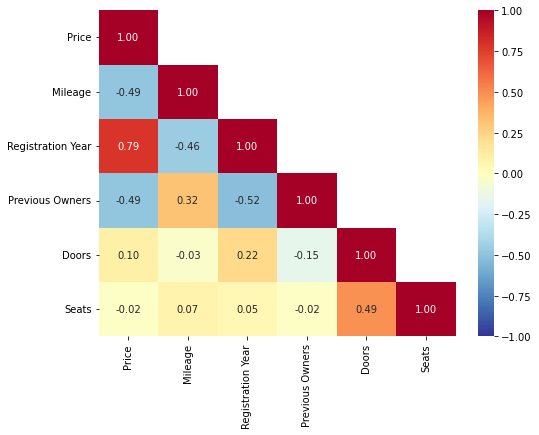

In [1007]:
# 변수별 상관관계 확인
corr = car_df.corr()

# 행렬이 대각선을 기준으로 대칭이기 때문에 하단만 표시하기 위한 마스크 생성
mask = np.zeros_like(corr) # np.zeros_like()는 0으로 가득찬 array 생성, 크기는 corr와 동일   
mask[np.triu_indices_from(mask, k=1)] = True # array의 대각선 영역과 그 윗 부분에 True가 들어가도록 설정

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
            cmap = 'RdYlBu_r',
            vmin=-1, vmax=1)
plt.show()

<br/><br/>
# 데이터 형태 변환

1. Engine 컬럼 값에서 각각 'L'을 제거하고 숫자로 타입 변환
2. 원핫인코딩 방식으로 'Model','Fuel Type','Body Type','Gearbox', 'Service History', 'Make', 'Country'의 카테고리 값들을 숫자로 변경
<br/><br/>

In [1008]:
# car_df 데이터 확인

car_df.head()

,Price,Mileage,Registration Year,Previous Owners,Fuel Type,Body Type,Engine,Gearbox,Doors,Seats,Emission Class,Service History,Make,Country
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,Unknown,SKODA,Czech Republic
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,United Kingdom
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,United Kingdom
5,800,124196,2007,3.0,Petrol,Coupe,2.0L,Manual,3.0,4.0,Euro 4,Unknown,HYUNDAI,South Korea
9,1299,87000,2008,5.0,Diesel,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,Unknown,PEUGEOT,France


In [1009]:
# car_df 데이터 형식 확인

car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239 entries, 0 to 3686
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              2239 non-null   int64  
 1   Mileage            2239 non-null   int64  
 2   Registration Year  2239 non-null   int64  
 3   Previous Owners    2239 non-null   float64
 4   Fuel Type          2239 non-null   object 
 5   Body Type          2239 non-null   object 
 6   Engine             2239 non-null   object 
 7   Gearbox            2239 non-null   object 
 8   Doors              2239 non-null   float64
 9   Seats              2239 non-null   float64
 10  Emission Class     2239 non-null   object 
 11  Service History    2239 non-null   object 
 12  Make               2239 non-null   object 
 13  Country            2239 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 262.4+ KB


In [1010]:
# Engine 컬럼 데이터를 숫자로 변경
# Engine은 카테고리형 데이터 대신 수치형 데이터에 적합하다고 생각하여 L를 삭제하고 숫자형으로 변환

car_df['Engine'] = pd.to_numeric(car_df['Engine'].str.replace('L', ''))

In [1011]:
# 원핫인코딩
# 'Fuel Type', 'Body Type', 'Gearbox', 'Emission Class', 'Make' 컬럼 데이터를 숫자로 변경
# 연산 부담을 줄이기 위해 컬럼 한 개 드랍 (drop_first = True)
# 컬럼 개수가 71개가 됨

oh_df = pd.get_dummies(car_df, columns = ['Fuel Type', 'Body Type', 'Gearbox', 'Emission Class', 'Service History', 'Make', 'Country'], drop_first = True)

In [1012]:
# 컬럼의 변화 확인

oh_df.head()

,Price,Mileage,Registration Year,Previous Owners,Engine,Doors,Seats,Fuel Type_Diesel Hybrid,Fuel Type_Petrol,Fuel Type_Petrol Hybrid,...,Country_Germany,Country_Italy,Country_Japan,Country_Malaysia,Country_Romania,Country_South Korea,Country_Spain,Country_Sweden,Country_United Kingdom,Country_United States
0,6900,70189,2016,3.0,1.4,5.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1495,88585,2008,4.0,1.2,3.0,5.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,2395,96731,2010,5.0,1.4,3.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,800,124196,2007,3.0,2.0,3.0,4.0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
9,1299,87000,2008,5.0,1.6,5.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1013]:
# 데이터 타입 확인

oh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239 entries, 0 to 3686
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            2239 non-null   int64  
 1   Mileage                          2239 non-null   int64  
 2   Registration Year                2239 non-null   int64  
 3   Previous Owners                  2239 non-null   float64
 4   Engine                           2239 non-null   float64
 5   Doors                            2239 non-null   float64
 6   Seats                            2239 non-null   float64
 7   Fuel Type_Diesel Hybrid          2239 non-null   uint8  
 8   Fuel Type_Petrol                 2239 non-null   uint8  
 9   Fuel Type_Petrol Hybrid          2239 non-null   uint8  
 10  Fuel Type_Petrol Plug-in Hybrid  2239 non-null   uint8  
 11  Body Type_Coupe                  2239 non-null   uint8  
 12  Body Type_Estate    

<br/><br/>
# 스케일링

* 특별히 이상치가 없어 Standard Scaler를 사용하기로 결정
<br/><br/>

In [1014]:
# 데이터 정보 확인
# 특별한 이상치가 없어 Standard Scaler를 사용하기로 결정

oh_df.describe()

,Price,Mileage,Registration Year,Previous Owners,Engine,Doors,Seats,Fuel Type_Diesel Hybrid,Fuel Type_Petrol,Fuel Type_Petrol Hybrid,...,Country_Germany,Country_Italy,Country_Japan,Country_Malaysia,Country_Romania,Country_South Korea,Country_Spain,Country_Sweden,Country_United Kingdom,Country_United States
count,2239.000000,2.239000e+03,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,...,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,5984.423403,8.293097e+04,2012.308620,2.805270,1.603082,4.410004,4.930773,0.000447,0.614113,0.016525,...,0.241626,0.029477,0.167039,0.000447,0.004466,0.050469,0.014739,0.014292,0.183117,0.119250
std,4761.228187,4.240144e+04,4.710367,1.540791,0.466897,0.937172,0.591974,0.021134,0.486913,0.127512,...,0.428164,0.169178,0.373094,0.021134,0.066696,0.218959,0.120532,0.118719,0.386849,0.324154
min,400.000000,6.000000e+00,1993.000000,1.000000,0.800000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2450.000000,5.839800e+04,2009.000000,2.000000,1.300000,4.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4250.000000,8.000000e+04,2012.000000,3.000000,1.600000,5.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8492.000000,1.050000e+05,2016.000000,4.000000,2.000000,5.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33900.000000,1.110100e+06,2023.000000,9.000000,6.300000,5.000000,7.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1015]:
# StandardScaler 객체 생성

ss = StandardScaler()

In [1016]:
# 학습. 연산에 필요한 정보(평균, 표준편차 값)를 획득

ss.fit(oh_df)

StandardScaler()

In [1017]:
# 스케일링 연산

ss_df = pd.DataFrame(ss.transform(oh_df), columns = oh_df.columns)

In [1018]:
# 스케일링 결과 확인

ss_df

,Price,Mileage,Registration Year,Previous Owners,Engine,Doors,Seats,Fuel Type_Diesel Hybrid,Fuel Type_Petrol,Fuel Type_Petrol Hybrid,...,Country_Germany,Country_Italy,Country_Japan,Country_Malaysia,Country_Romania,Country_South Korea,Country_Spain,Country_Sweden,Country_United Kingdom,Country_United States
0,0.192341,-0.300575,0.783847,0.126411,-0.435057,0.629689,0.116969,-0.021138,-1.261521,-0.129626,...,-0.564456,-0.174278,-0.447813,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,-0.473462,-0.367961
1,-0.943124,0.133375,-0.914914,0.775573,-0.863513,-1.504867,0.116969,-0.021138,0.792694,-0.129626,...,-0.564456,-0.174278,-0.447813,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,2.112102,-0.367961
2,-0.754054,0.325534,-0.490224,1.424735,-0.435057,-1.504867,-1.572671,-0.021138,0.792694,-0.129626,...,-0.564456,-0.174278,-0.447813,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,2.112102,-0.367961
3,-1.089127,0.973416,-1.127260,0.126411,0.850309,-1.504867,-1.572671,-0.021138,0.792694,-0.129626,...,-0.564456,-0.174278,-0.447813,-0.021138,-0.06698,4.337529,-0.122308,-0.120413,-0.473462,-0.367961
4,-0.984299,0.095986,-0.914914,1.424735,-0.006602,0.629689,0.116969,-0.021138,-1.261521,-0.129626,...,-0.564456,-0.174278,-0.447813,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,-0.473462,-0.367961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,-0.679477,0.402648,-1.764295,0.126411,4.492179,0.629689,0.116969,-0.021138,0.792694,-0.129626,...,-0.564456,-0.174278,-0.447813,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,-0.473462,2.717677
2235,-0.737248,1.725941,-3.038366,-0.522751,1.278764,-2.572146,-1.572671,-0.021138,0.792694,-0.129626,...,-0.564456,-0.174278,2.233077,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,-0.473462,-0.367961
2236,-0.901108,0.497005,-0.702569,0.126411,-0.006602,0.629689,0.116969,-0.021138,0.792694,-0.129626,...,-0.564456,-0.174278,2.233077,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,-0.473462,-0.367961
2237,-0.964131,-0.158732,-1.339605,0.775573,-0.006602,0.629689,0.116969,-0.021138,0.792694,-0.129626,...,-0.564456,-0.174278,-0.447813,-0.021138,-0.06698,-0.230546,-0.122308,-0.120413,-0.473462,-0.367961


<br/><br/>
# 주성분(PCA) 추출

* 주성분 56개(95%) 선택
<br/><br/>

In [1019]:
# PCA 객체 생성하여 적용

pca = PCA().fit(ss_df)

In [1020]:
# Explained Variance의 누적합 계산

explained_variance_ratio = pca.explained_variance_ratio_ # explained_variance_ratio_: Explained Variance 비율을 계산해 주는 함수
cumulative_explained_variance = np.cumsum(explained_variance_ratio) # cumsum: 각 원소의 누적합을 계산하는 함수

In [ ]:
# Explained Variance의 누적합 시각화

plt.figure(figsize=(15, 8)) 

# 각 성분의 설명된 분포에 대한 막대 그래프
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)), y=explained_variance_ratio, alpha=0.8)

# 누적 분포에 대한 선 그래프
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', linewidth=2)

# 레이블과 제목 설정
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# 눈금 및 범례 사용자 정의
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance', 'Cumulative Explained Variance'])  

# 두 그래프의 분산 값 표시
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [ ]:
# 주성분 56개(95%)에 관한 데이터프레임 생성
# 95% 정도면 원 데이터를 많이 커버하면서 차원도 81개 -> 56개로 줄여

pca = PCA(n_components=56)
pca_df = pd.DataFrame(pca.fit_transform(ss_df), columns=['PC'+str(i+1) for i in range(pca.n_components_)])

In [ ]:
# 결과 출력

pca_df.head()

<br/><br/>
# 국가별 총 브랜드 개수
<br/><br/>

In [ ]:
car_df.groupby('Country').Make.nunique().to_frame()

<br/><br/>
# 회고

* Previous Owners 결측치가 1,411개(38%)로 꽤 높아서 어떻게 처리할지 고민되었다. <br/>너무 많은 데이터가 지워질 것 같아서 중앙값을 채울까 하다가 예측 성능에 영향을 줄까 하여 삭제하였다.<br/>결정이 바른 판단일지, 케이스별로 적합한 방법에는 무엇이 있을지 알아봐야겠다.
* 자동차 모델명 종류가 너무 많아 모델에 영향을 줄 것 같아서 모델명 컬럼을 삭제하고 진행하였다. 바른 판단일지 더 나은 방법이 있을지 알아봐야겠다.
* 자동차 모델명과 같이 값 종류가 매우 다양해서 정리하는 게 좋은 경우, 효율적으로 정리하는 방법에는 무엇이 있을지 알아봐야겠다.
<br/><br/>